# Improved Aeroelasticity Data Preprocessing

This notebook implements an improved preprocessing pipeline for the aeroelasticity prediction project. 
It addresses the feedback from the critical review, specifically:
1.  **Updated Data Paths:** Reads from `/Volumes/MHSSD/Projects/aeroelasticity/data`.
2.  **Physics-Based Feature Engineering:** Computes $\phi$, $Re$, and centered $\alpha_0$.
3.  **Clean Output:** Saves processed data to `processed_data/improved_ml_dataset.npz` and `processed_data/improved_psd_dataset.h5`.

## Features
- **$\phi$ (Shape Parameter):** $\arctan(2H/D)$
- **$Re$ (Reynolds Number):** $(U_{ref} \cdot D) / \nu$
- **$\alpha_0$ (Centered AoA):** $\text{radians}(\text{AoA} - 90)$

In [7]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.signal import welch
import h5py
from tqdm import tqdm
import re

# Configuration
BASE_PATH = "/Volumes/MHSSD/Projects/aeroelasticity/data"
PROCESSED_DIR = "processed_data"
NU = 1.0e-5  # Kinematic viscosity (m^2/s)

# Ensure output directory exists
os.makedirs(PROCESSED_DIR, exist_ok=True)

## 1. Data Reader Classes

In [8]:
class ForceCoeffsReader:
    """Reads OpenFOAM forceCoeffs.dat files"""
    
    def __init__(self, file_path):
        self.file_path = Path(file_path)
        
    def read(self):
        """Read force coefficients file"""
        data = []
        try:
            with open(self.file_path, 'r') as f:
                for line in f:
                    if line.startswith('#'):
                        continue
                    # Parse line
                    parts = line.replace('(', '').replace(')', '').split()
                    if len(parts) >= 4:
                        try:
                            # time, Cm, Cd, Cl
                            # Note: OpenFOAM forceCoeffs usually: time, Cm, Cd, Cl, Cl(f), Cl(r)
                            # Adjust indices based on standard OpenFOAM output or specific file format
                            # Assuming: Time, Cm, Cd, Cl
                            t = float(parts[0])
                            cm = float(parts[1])
                            cd = float(parts[2])
                            cl = float(parts[3])
                            data.append([t, cm, cd, cl])
                        except ValueError:
                            continue
                            
            if not data:
                print(f"Warning: No data found in {self.file_path}")
                return None
                
            df = pd.DataFrame(data, columns=['time', 'cm', 'cd', 'cl'])
            return df
            
        except Exception as e:
            print(f"Error reading {self.file_path}: {e}")
            return None

In [9]:
class ForceProcessor:
    """Processes force time series data"""
    
    def __init__(self, df, t_start=None):
        self.df = df
        if t_start is not None:
            self.df = self.df[self.df['time'] >= t_start]
            
    def compute_statistics(self):
        """Compute mean and std of coefficients"""
        stats = {}
        for col in ['cd', 'cl', 'cm']:
            stats[f'mean_{col}'] = self.df[col].mean()
            stats[f'std_{col}'] = self.df[col].std()
        return stats
        
    def compute_psd(self, col='cl', fs=None):
        """Compute Power Spectral Density using Welch's method"""
        if fs is None:
            # Estimate sampling frequency
            dt = np.mean(np.diff(self.df['time']))
            fs = 1.0 / dt
            
        x = self.df[col].values
        # Remove mean
        x = x - np.mean(x)
        
        freqs, psd = welch(x, fs, nperseg=1024)
        return freqs, psd, fs

    def compute_psd_strouhal(self, u_ref, D, st_grid, col='cl', fs=None):
        """Compute Log-PSD on a fixed Strouhal grid"""
        if fs is None:
            dt = np.mean(np.diff(self.df['time']))
            fs = 1.0 / dt
            
        x = self.df[col].values
        x = x - np.mean(x)
        
        # Welch's method
        freqs, psd = welch(x, fs, nperseg=1024)
        
        # Convert to Strouhal: St = f * D / U_ref
        st = freqs * D / u_ref
        
        # Interpolate onto fixed Strouhal grid
        # Use log10(PSD) for better scaling
        # Add epsilon to avoid log(0)
        log_psd = np.log10(psd + 1e-10)
        
        # Interpolate
        log_psd_interp = np.interp(st_grid, st, log_psd)
        
        return log_psd_interp

    def filter_and_downsample(self, fs_target=100.0, f_cutoff=40.0):
        """Low-pass filter and downsample the signal"""
        from scipy.signal import butter, filtfilt, resample
        
        # Estimate current fs
        dt = np.mean(np.diff(self.df['time']))
        fs = 1.0 / dt
        
        if fs <= fs_target:
            return self.df
            
        # Low-pass filter
        nyq = 0.5 * fs
        normal_cutoff = f_cutoff / nyq
        b, a = butter(4, normal_cutoff, btype='low', analog=False)
        
        for col in ['cl', 'cd', 'cm']:
            self.df[col] = filtfilt(b, a, self.df[col])
            
        # Downsample
        num_samples = int(len(self.df) * fs_target / fs)
        
        # Resample time and data
        new_time = np.linspace(self.df['time'].iloc[0], self.df['time'].iloc[-1], num_samples)
        
        new_data = {'time': new_time}
        for col in ['cl', 'cd', 'cm']:
            # Linear interpolation is safer for non-periodic transient data
            new_data[col] = np.interp(new_time, self.df['time'], self.df[col])
            
        return pd.DataFrame(new_data)


## 2. Main Data Processor

In [10]:
class AeroelasticDataProcessor:
    def __init__(self, base_path):
        self.base_path = Path(base_path)
        
        # Shape parameters (D=3.0m constant)
        self.shape_params = {
            'baseline': {'D': 3.0, 'H': 1.5},
            'baseline_lowU': {'D': 3.0, 'H': 1.5},
            'baseline_mediumU': {'D': 3.0, 'H': 1.5},
            'taller': {'D': 3.0, 'H': 2.0},
            'shorter': {'D': 3.0, 'H': 1.0}
        }
        
    def extract_metadata_from_header(self, file_path):
        """Extract U_ref and lRef from forceCoeffs.dat header"""
        u_ref = None
        lRef = None
        try:
            with open(file_path, 'r') as f:
                for line in f:
                    if line.startswith('# magUInf'):
                        parts = line.split(':')
                        if len(parts) > 1:
                            u_ref = float(parts[1].strip())
                    elif line.startswith('# lRef'):
                        parts = line.split(':')
                        if len(parts) > 1:
                            lRef = float(parts[1].strip())
                    elif not line.startswith('#'):
                        break
            return u_ref, lRef
        except Exception as e:
            print(f"Error reading header of {file_path}: {e}")
            return None, None
        
    def scan_and_process(self):
        """Scan directories and process all data"""
        summary_data = []
        time_series_data = {}
        
        if not self.base_path.exists():
            print(f"Base path {self.base_path} does not exist.")
            return pd.DataFrame(), {}
        
        shape_dirs = [d for d in self.base_path.iterdir() if d.is_dir() and d.name in self.shape_params]
        
        print(f"Found {len(shape_dirs)} matching shape directories in {self.base_path}")
        
        for shape_dir in tqdm(shape_dirs, desc="Processing shapes"):
            shape_name = shape_dir.name
            D = self.shape_params[shape_name]['D']
            H = self.shape_params[shape_name]['H']
            
            angle_dirs = [d for d in shape_dir.iterdir() if d.is_dir()]
            
            for angle_dir in angle_dirs:
                try:
                    angle = float(angle_dir.name)
                except ValueError:
                    continue
                    
                force_file = angle_dir / 'postProcessing' / 'cylinder' / '0' / 'forceCoeffs.dat'
                
                if not force_file.exists():
                    continue
                    
                # Extract U_ref from header OR directory name
                u_ref, lRef = self.extract_metadata_from_header(force_file)
                
                # Override U_ref for low/medium speed cases
                if 'baseline_lowU' in shape_name:
                    u_ref = 5.0
                elif 'baseline_mediumU' in shape_name:
                    u_ref = 10.0
                elif u_ref is None:
                    print(f"Could not extract U_ref from {force_file}")
                    continue
                    
                reader = ForceCoeffsReader(force_file)
                df = reader.read()
                if df is None or len(df) < 100:
                    continue
                    
                # Process
                t_start = df['time'].iloc[-1] * 0.2
                processor = ForceProcessor(df, t_start=t_start)
                
                # Filter and Downsample
                df_filtered = processor.filter_and_downsample(fs_target=100.0, f_cutoff=40.0)
                processor = ForceProcessor(df_filtered)
                
                stats = processor.compute_statistics()
                
                # Compute Strouhal Grid PSD (Linear Grid)
                # Reverting to linear grid as log-grid reduced performance
                st_grid = np.linspace(0.05, 5.0, 128)
                log_psd_st = processor.compute_psd_strouhal(u_ref, D, st_grid, col='cl')
                
                # Find peak
                peak_idx = np.argmax(log_psd_st)
                st_peak = st_grid[peak_idx]
                f_peak = st_peak * u_ref / D
                
                case_id = f"{shape_name}_{int(angle)}"
                
                # Compute New Features
                # alpha_apex (radians)
                alpha_apex = 2 * np.arctan(D / (2*H))
                
                # alpha0 (radians)
                alpha0 = np.radians(angle - 90)
                sin_alpha0 = np.sin(alpha0)
                cos_alpha0 = np.cos(alpha0)
                
                # Re
                Re = (u_ref * D) / NU
                
                entry = {
                    'case_id': case_id,
                    'shape': shape_name,
                    'angle': angle,
                    'U_ref': u_ref,
                    'D': D,
                    'H': H,
                    'lRef': lRef,
                    'st_peak': st_peak,
                    'f_peak': f_peak,
                    'alpha_apex': alpha_apex,
                    'alpha0': alpha0,
                    'sin_alpha0': sin_alpha0,
                    'cos_alpha0': cos_alpha0,
                    'Re': Re,
                    **stats
                }
                summary_data.append(entry)
                
                time_series_data[case_id] = {
                    'time': df_filtered['time'].values,
                    'cl': df_filtered['cl'].values,
                    'cd': df_filtered['cd'].values,
                    'cm': df_filtered['cm'].values,
                    'st_grid': st_grid,
                    'log_psd': log_psd_st,
                    'metadata': {
                        'shape': shape_name,
                        'angle': angle,
                        'U_ref': u_ref,
                        'D': D,
                        'H': H
                    }
                }
                
        return pd.DataFrame(summary_data), time_series_data


## 3. Create Improved ML Dataset

In [11]:
def create_improved_ml_dataset(summary_df, time_series_data):
    """
    Create final NPZ and H5 datasets for ML
    """
    print("Creating ML dataset...")
    
    # 1. Extract Features (X)
    # New Feature Set: [alpha_apex, Re, sin_alpha0, cos_alpha0]
    feature_cols = ['alpha_apex', 'Re', 'sin_alpha0', 'cos_alpha0']
    X = summary_df[feature_cols].values.astype(np.float32)
    
    # 2. Extract Targets (y) - Scalars
    target_cols = ['mean_cd', 'mean_cl', 'mean_cm', 'st_peak']
    y = summary_df[target_cols].values.astype(np.float32)
    
    # Compute Normalization Statistics for X
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    # Avoid division by zero
    X_std[X_std == 0] = 1.0
    
    case_ids = summary_df['case_id'].values
    
    # 3. Save to NPZ
    npz_path = os.path.join(PROCESSED_DIR, "improved_ml_dataset.npz")
    np.savez(
        npz_path,
        X=X,
        y=y,
        X_mean=X_mean,
        X_std=X_std,
        case_ids=case_ids,
        feature_names=feature_cols,
        target_names=target_cols
    )
    print(f"Saved ML dataset to {npz_path}")
    
    # 4. Save Time Series and Spectral Data to H5
    h5_path = os.path.join(PROCESSED_DIR, "improved_psd_dataset.h5")
    with h5py.File(h5_path, 'w') as f:
        for case_id in case_ids:
            grp = f.create_group(case_id)
            ts_data = time_series_data[case_id]
            
            grp.create_dataset('time', data=ts_data['time'])
            grp.create_dataset('cl', data=ts_data['cl'])
            grp.create_dataset('cd', data=ts_data['cd'])
            grp.create_dataset('cm', data=ts_data['cm'])
            grp.create_dataset('st_grid', data=ts_data['st_grid'])
            grp.create_dataset('log_psd', data=ts_data['log_psd'])
            
            for k, v in ts_data['metadata'].items():
                grp.attrs[k] = v
                
    print(f"Saved H5 dataset to {h5_path}")
    
    # Save summary CSV
    csv_path = os.path.join(PROCESSED_DIR, "preprocessing_summary.csv")
    summary_df.to_csv(csv_path, index=False)
    print(f"Saved summary to {csv_path}")
    
    return summary_df


## 4. Execution

In [12]:
# Initialize processor
processor = AeroelasticDataProcessor(BASE_PATH)

# Scan and process
summary_df, time_series_data = processor.scan_and_process()

if not summary_df.empty:
    print(f"Processed {len(summary_df)} cases.")
    print(summary_df.head())
    
    # Create ML dataset
    final_df = create_improved_ml_dataset(summary_df, time_series_data, PROCESSED_DIR)
    
    # Save CSV for inspection
    final_df.to_csv(Path(PROCESSED_DIR) / "preprocessing_summary.csv", index=False)
    print("Saved summary CSV.")
else:
    print("No data found or processed!")

Found 5 matching shape directories in /Volumes/MHSSD/Projects/aeroelasticity/data


Processing shapes: 100%|██████████| 5/5 [00:47<00:00,  9.41s/it]

Processed 75 cases.
       case_id     shape  angle  U_ref    D    H  lRef   st_peak   f_peak  \
0  baseline_85  baseline   85.0   21.5  3.0  1.5   1.5  0.545058  3.90625   
1  baseline_75  baseline   75.0   21.5  3.0  1.5   1.5  0.545058  3.90625   
2  baseline_70  baseline   70.0   21.5  3.0  1.5   1.5  0.545058  3.90625   
3  baseline_65  baseline   65.0   21.5  3.0  1.5   1.5  0.545058  3.90625   
4  baseline_60  baseline   60.0   21.5  3.0  1.5   1.5  0.545058  3.90625   

    mean_cd    std_cd   mean_cl    std_cl   mean_cm    std_cm  
0  2.708736  0.230504  0.333842  0.927156  1.997957  0.438839  
1  3.161294  0.274192 -1.201776  0.545095  1.564579  0.738615  
2  3.495747  0.282601 -1.670559  0.560382  1.318252  0.782452  
3  3.779042  0.315196 -2.119308  0.571620  1.011528  0.813680  
4  3.811960  0.322730 -2.647629  0.536947  0.537640  0.809235  
Creating improved ML dataset...
Saved ML features to processed_data/improved_ml_dataset.npz
Saved time series data to processed_data/

In [13]:
# Mock Data Generation (for testing if no data is present)
if summary_df.empty:
    print("Generating mock data for verification...")
    mock_data = []
    mock_ts = {}
    
    shapes = ['baseline', 'taller', 'shorter']
    angles = range(60, 120, 5)
    speeds = [10.0, 15.0]
    
    for s in shapes:
        for a in angles:
            for u in speeds:
                case_id = f"{s}_{u}ms_{a}deg"
                D = 3.0
                H = 1.5 if s == 'baseline' else (2.0 if s == 'taller' else 1.0)
                
                # Mock physics
                phi = np.arctan2(2*H, D)
                alpha0 = np.radians(a - 90)
                Re = (u * D) / NU
                
                # Mock Cl time series
                t = np.linspace(0, 10, 1000)
                # Simple sine wave based on Strouhal ~ 0.15
                f_shed = 0.15 * u / D
                cl = 0.5 * np.sin(2 * np.pi * f_shed * t) + 0.1 * np.random.randn(len(t))
                
                entry = {
                    'case_id': case_id,
                    'shape': s,
                    'U_ref': u,
                    'angle': a,
                    'D': D,
                    'H': H,
                    'mean_cl': np.mean(cl),
                    'mean_cd': 1.2,
                    'mean_cd': 1.2,
                    'mean_cm': 0.05,
                    'st_peak': 0.15
                }
                mock_data.append(entry)
                
                mock_ts[case_id] = {
                    'time': t,
                    'cl': cl,
                    'cd': np.ones_like(t) * 1.2,
                    'cm': np.ones_like(t) * 0.05,
                    'metadata': {'D': D, 'H': H, 'U_ref': u, 'angle': a}
                }
    
    mock_df = pd.DataFrame(mock_data)
    create_improved_ml_dataset(mock_df, mock_ts, PROCESSED_DIR)
    print("Mock data generated and saved.")

## 5. Verification and Visualization

Loaded 75 cases.
Features: ['phi' 'Re' 'alpha0']


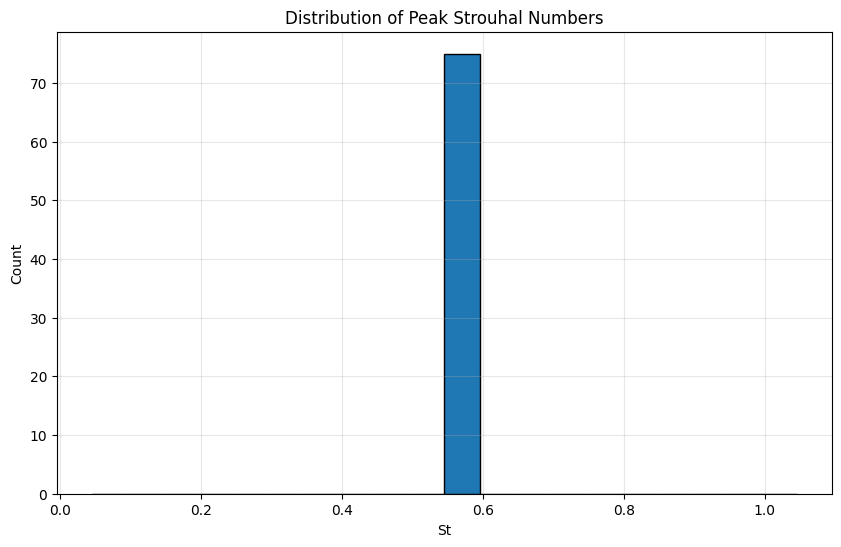

Visualizing Case: baseline_60


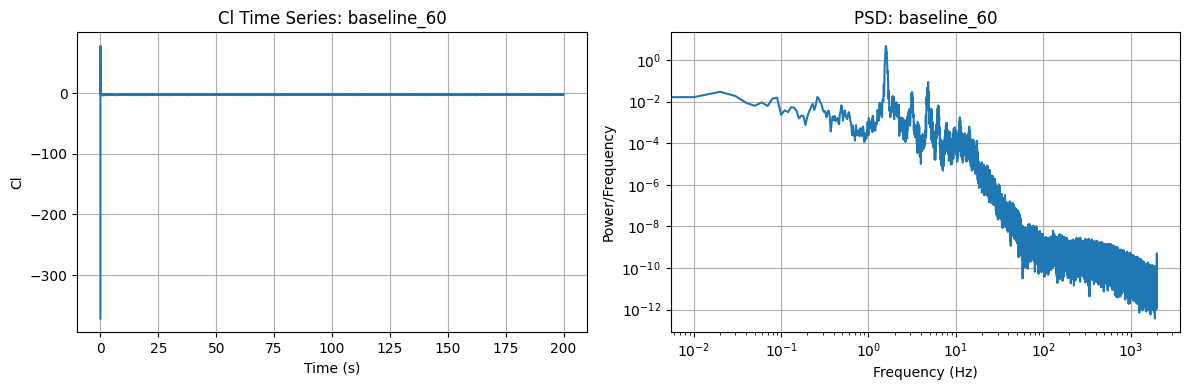

Attributes:
  D: 3.0
  H: 1.5
  Re: 6449999.999999999
  U_ref: 21.5
  alpha0: -0.5235987755982988
  angle: 60.0
  phi: 0.7853981633974483
  shape: baseline
  st_peak: 0.5450581395348837


In [19]:
def verify_and_visualize(output_dir):
    """Verify processed data and visualize samples"""
    npz_path = Path(output_dir) / "improved_ml_dataset.npz"
    h5_path = Path(output_dir) / "improved_psd_dataset.h5"
    
    if not npz_path.exists() or not h5_path.exists():
        print("Data files not found for verification.")
        return
        
    # Load summary data
    data = np.load(npz_path, allow_pickle=True)
    X = data['X']
    y = data['y']
    case_ids = data['case_ids']
    feature_names = data['feature_names']
    
    print(f"Loaded {len(case_ids)} cases.")
    print(f"Features: {feature_names}")
    
    # Plot Strouhal Number Distribution
    st_peaks = y[:, 3]  # Assuming st_peak is the 4th target
    plt.figure(figsize=(10, 6))
    plt.hist(st_peaks, bins=20, edgecolor='k')
    plt.title("Distribution of Peak Strouhal Numbers")
    plt.xlabel("St")
    plt.ylabel("Count")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Visualize a random case
    if len(case_ids) > 0:
        idx = np.random.randint(0, len(case_ids))
        case_id = case_ids[idx]
        print(f"Visualizing Case: {case_id}")
        
        with h5py.File(h5_path, 'r') as f:
            if case_id in f:
                grp = f[case_id]
                time = grp['time'][:]
                cl = grp['cl'][:]
                
                # Plot Time Series
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 2, 1)
                plt.plot(time, cl)
                plt.title(f"Cl Time Series: {case_id}")
                plt.xlabel("Time (s)")
                plt.ylabel("Cl")
                plt.grid(True)
                
                # Plot PSD
                dt = np.mean(np.diff(time))
                fs = 1.0 / dt
                freqs, psd = welch(cl - np.mean(cl), fs, nperseg=len(cl)//2)
                
                plt.subplot(1, 2, 2)
                plt.loglog(freqs, psd)
                plt.title(f"PSD: {case_id}")
                plt.xlabel("Frequency (Hz)")
                plt.ylabel("Power/Frequency")
                plt.grid(True)
                plt.tight_layout()
                plt.show()
                
                print("Attributes:")
                for k, v in grp.attrs.items():
                    print(f"  {k}: {v}")

verify_and_visualize(PROCESSED_DIR)